In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams["font.family"] = "Calibri"


def find_outliers(df, threshold=2):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Skip the "t1" and "t2" columns
        if col == "t1" or col == "t2":
            continue

        # Calculate the mean and standard deviation of the column
        mean = df[col].mean()
        std = df[col].std()

        # Find outliers in this column
        outliers = (df[col] - mean).abs() > threshold * std

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers)

    # Return the indices of the outliers
    outlier_indices = df[outlier_rows_mask].index
    return outlier_indices

In [49]:
df = pd.read_csv("../outputs/data_clean_glass_lai_icos.csv")
df.set_index(pd.to_datetime(df.iloc[:, 0], format="%Y-%m-%d"), inplace=True)
df = df.drop(df.columns[0], axis=1)

ameriflux_coords = pd.read_csv("../data/Ameriflux_coords.csv")
fluxnet_coords = pd.read_csv("../data/Fluxnet_coords.csv")
icos_coords = pd.read_csv("../data/Icos_coords.csv")
icos_coords.drop(["site_name", "ID"], axis=1, inplace=True)
icos_coords.rename({"name": "Name"}, axis=1, inplace=True)
merged_coords = pd.concat([ameriflux_coords, fluxnet_coords, icos_coords], axis=0)
merged_coords.drop_duplicates(subset=merged_coords.columns[0], inplace=True)
merged_coords.reset_index(drop=True, inplace=True)
merged_coords.rename({"Name": "name"}, axis=1, inplace=True)

### Selecting sites

- They should have at least two years of data
- Sort descending based on LUE
- Take the median of the top X percent of the sorted data


In [51]:
names = df["name"].unique()
types = df["type"].unique()

site_annual_max_lue = []
site_annual_max_lue_se = []

for name in names:
    site_df = df[df["name"] == name]
    n_years = len(site_df.index.year.unique())
    if n_years < 2:
        continue
    type = site_df["type"].iloc[0]
    site_df = site_df[
        ["fpar", "nirv", "nirvp", "fesc", "lue", "lai", "glass_lai", "apar"]
    ]
    # Sort based on the "lue" column
    site_df_sorted = site_df.sort_values("lue", ascending=False)

    # Find the 5% threshold
    thresh = np.round(len(site_df_sorted) * 0.1)
    site_df_max = site_df_sorted.iloc[0 : int(thresh)]
    annual_max_mean = site_df_max.median()
    annual_max_mean.loc["type"] = type
    annual_max_mean.loc["name"] = name
    annual_max_std = site_df_max.std()
    n = len(site_df_max)
    annual_max_se = annual_max_std / np.sqrt(n)
    annual_max_se.loc["type"] = type
    annual_max_se.loc["name"] = name

    site_annual_max_lue.append(annual_max_mean)
    site_annual_max_lue_se.append(annual_max_se)

site_annual_max_lue = pd.DataFrame(site_annual_max_lue)
site_annual_max_lue_se = pd.DataFrame(site_annual_max_lue_se)
len(site_annual_max_lue)

325

In [52]:
site_annual_max_lue = pd.merge(
    site_annual_max_lue, merged_coords[["name", "Lat", "Lon"]], on="name", how="left"
)

In [53]:
def assign_type(row):
    if row["type"] == "EBF":
        if -23.5 <= row["Lat"] <= 23.5:
            return "tropical_EBF"
        else:
            return "mid_EBF"
    else:
        return row["type"]


site_annual_max_lue["new_type"] = site_annual_max_lue.apply(assign_type, axis=1)
site_annual_max_lue["type"] = site_annual_max_lue["new_type"]

In [54]:
# Convert the index to a separate column
df.reset_index(inplace=True)

# Rename the new column to 'date'
df.rename(columns={"index": "date"}, inplace=True)
df = pd.merge(df, merged_coords[["name", "Lat", "Lon"]], on="name", how="left")
df.rename(columns={"Unnamed: 0": "date"}, inplace=True)
df["new_type"] = df.apply(assign_type, axis=1)

In [55]:
# Select the columns to find outliers in
columns_to_check = ["lue", "fesc", "fpar", "nirv", "nirvp", "lai", "glass_lai", "apar"]

# Create a copy of the DataFrame with only the columns to check
df_to_check = site_annual_max_lue[columns_to_check].copy()

# Use the find_outliers function to find the indices of the outliers
outlier_indices = find_outliers(df_to_check, threshold=3)

# Drop the rows with outliers from the original DataFrame
# site_annual_max_lue_clean = site_annual_max_lue.drop(outlier_indices)
# site_annual_max_lue = site_annual_max_lue_clean
site_annual_max_lue = site_annual_max_lue.groupby("type").filter(lambda x: len(x) >= 3)
# site_annual_max_lue.to_csv("../outputs/plotting_data_percentile.csv", index=False)

In [56]:
types = site_annual_max_lue["type"].unique()
names = site_annual_max_lue["name"].unique()

In [57]:
counts_df = pd.DataFrame(columns=["type", "sites", "days"])

for type in types:
    site_count = len(site_annual_max_lue[site_annual_max_lue["type"] == type])
    days = len(df[df["new_type"] == type])
    counts_df.loc[len(counts_df)] = [type, site_count, days]
print("Number of sites and days for each type:")
counts_df

Number of sites and days for each type:


,type,sites,days
0,DBF,43,43629
1,mid_EBF,8,10898
2,GRA,57,51284
3,CRO,39,40630
4,MF,12,10143
5,WET,34,25751
6,ENF,73,66894
7,OSH,25,25016
8,WSA,9,18751
9,SAV,10,12173


/tmp/ipykernel_1190051/2831551022.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


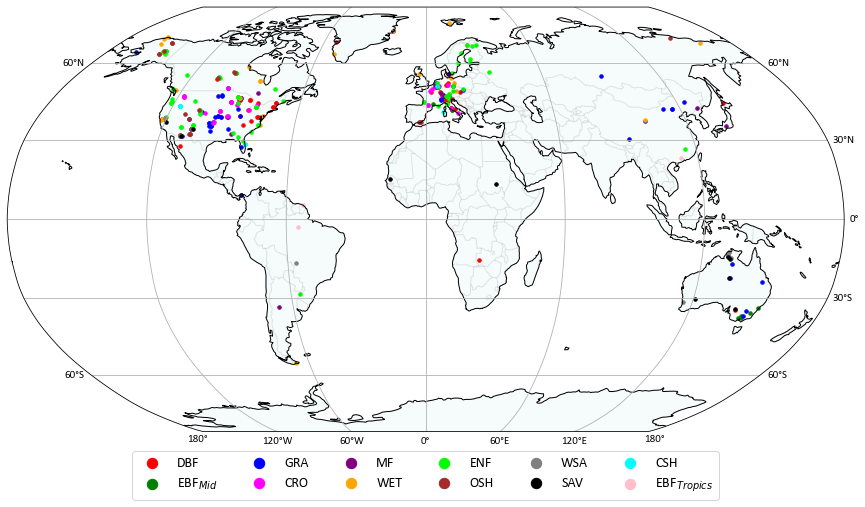

In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the world boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Create a GeoDataFrame from your data
gdf = gpd.GeoDataFrame(
    site_annual_max_lue,
    geometry=gpd.points_from_xy(site_annual_max_lue.Lon, site_annual_max_lue.Lat),
)

# Define a dictionary of colors for each site type
colors = [
    "red",
    "green",
    "blue",
    "magenta",
    "purple",
    "orange",
    "lime",
    "brown",
    "gray",
    "black",
    "cyan",
    "pink",
    "yellow",
]
type_color_dict = dict(zip(types, colors))

# Create a larger figure and plot the world
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(
    cfeature.LAND, color="lightblue", alpha=0.1
)  # add a faint blue color to the land
ax.coastlines()
ax.add_feature(cfeature.BORDERS, alpha=0.1)
gridlines = ax.gridlines(draw_labels=True)
gridlines.top_labels = False
gridlines.left_labels = False

gridlines.xlabel_style = {"size": 11, "color": "black"}
gridlines.ylabel_style = {"size": 11, "color": "black"}

# Plot the sites with different colors based on the type
for site_type in types:
    site_data = gdf[gdf["type"] == site_type]
    label = site_type
    if site_type == "mid_EBF":
        label = "EBF$_{Mid}$"  # Convert 'mid_EBF' to 'EBFMid' with 'Mid' as subscript
    if site_type == "tropical_EBF":
        label = "EBF$_{Tropics}$"
    scatter = ax.scatter(
        site_data["Lon"],
        site_data["Lat"],
        color=type_color_dict[site_type],
        s=12,
        transform=ccrs.PlateCarree(),
        label=label,
    )
# Add a legend at the bottom
legend = ax.legend(
    bbox_to_anchor=(0.5, -0.03), loc="upper center", ncol=6, fontsize=14, markerscale=3
)

# Make the legend fonts bold
# plt.setp(legend.get_texts(), fontweight="bold")


plt.savefig("../outputs/figures/annual_max_lue_map.png", dpi=300, bbox_inches="tight")

In [213]:
site_annual_max_lue = site_annual_max_lue[site_annual_max_lue["fesc"] <= 1]
site_annual_max_lue_se = site_annual_max_lue_se[
    site_annual_max_lue_se.index.isin(site_annual_max_lue.index)
]
site_annual_max_lue_grouped_mean = (
    site_annual_max_lue[
        ["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai", "glass_lai", "apar"]
    ]
    .groupby("type")
    .mean()
)
site_annual_max_lue_grouped_std = (
    site_annual_max_lue[
        ["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai", "glass_lai", "apar"]
    ]
    .groupby("type")
    .std()
)
n = site_annual_max_lue.groupby("type").size()
site_annual_max_lue_grouped_se = site_annual_max_lue_grouped_std.div(np.sqrt(n), axis=0)
site_annual_max_lue_grouped_mean.to_csv("../outputs/anual_mean_values.csv")
site_annual_max_lue_grouped_se.to_csv("../outputs/anual_se_values.csv")

In [214]:
def format_mean_se(mean, se):
    return f"{mean:.4f} ± {se:.4f}"


table = site_annual_max_lue_grouped_mean.copy()

for column in site_annual_max_lue_grouped_mean.columns:
    table[column] = site_annual_max_lue_grouped_mean[column].combine(
        site_annual_max_lue_grouped_se[column], func=format_mean_se
    )
table.to_csv("../outputs/mean_se_table.csv")
print(table)

                         fpar             nirv              nirvp  \
type                                                                
CRO           0.6198 ± 0.0161  0.2592 ± 0.0114  106.2994 ± 7.5235   
CSH           0.4582 ± 0.0893  0.1186 ± 0.0182   36.3781 ± 4.5878   
DBF           0.7570 ± 0.0244  0.2801 ± 0.0117   75.6045 ± 4.2200   
ENF           0.5961 ± 0.0170  0.1424 ± 0.0048   28.8284 ± 1.5950   
GRA           0.5122 ± 0.0245  0.1770 ± 0.0105   50.8905 ± 4.0301   
MF            0.7082 ± 0.0495  0.2133 ± 0.0191   44.9953 ± 4.7909   
OSH           0.3509 ± 0.0436  0.1039 ± 0.0123   29.1072 ± 2.2112   
SAV           0.3619 ± 0.0458  0.1091 ± 0.0164   44.4555 ± 8.0437   
WET           0.5762 ± 0.0279  0.1796 ± 0.0108   48.4124 ± 4.8739   
WSA           0.4537 ± 0.0476  0.1312 ± 0.0167  53.0544 ± 11.1144   
mid_EBF       0.7099 ± 0.0584  0.1527 ± 0.0092   22.1284 ± 1.7885   
tropical_EBF  0.8598 ± 0.0312  0.2336 ± 0.0398  75.4426 ± 30.2373   

                         fesc    

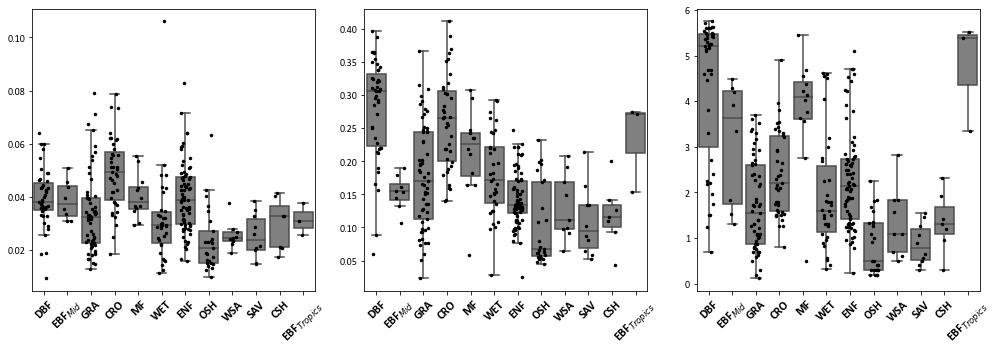

In [215]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

# Plot the boxplot of "lue" on the first subplot
sns.boxplot(
    x="type", y="lue", data=site_annual_max_lue, showfliers=False, ax=ax1, color="gray"
)
sns.stripplot(
    x="type",
    y="lue",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax1,
)
# ax1.set_ylabel(r"$\bar{LUE_{Max}}$", fontsize=14, weight="bold")
ax1.set_ylabel("")
ax1.set_xlabel("")

# Plot the boxplot of "fesc" on the second subplot
sns.boxplot(
    x="type", y="nirv", data=site_annual_max_lue, showfliers=False, ax=ax2, color="gray"
)
sns.stripplot(
    x="type",
    y="nirv",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax2,
)
ax2.set_ylabel("", fontsize=14, weight="bold")
ax2.set_xlabel("")

# Plot the boxplot of "fesc" on the second subplot
sns.boxplot(
    x="type",
    y="glass_lai",
    data=site_annual_max_lue,
    showfliers=False,
    ax=ax3,
    color="gray",
)
sns.stripplot(
    x="type",
    y="glass_lai",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax3,
)
ax3.set_ylabel("", fontsize=16, weight="bold")
ax3.set_xlabel("")

for label in ax1.get_xticklabels():
    label.set_weight("bold")
for label in ax2.get_xticklabels():
    label.set_weight("bold")
for label in ax3.get_xticklabels():
    label.set_weight("bold")

for ax in [ax1, ax2, ax3]:
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = ["EBF$_{Mid}$" if label == "mid_EBF" else label for label in labels]
    labels = [
        "EBF$_{Tropics}$" if label == "tropical_EBF" else label for label in labels
    ]
    ax.set_xticklabels(labels)

ax1.tick_params(axis="x", rotation=45, labelsize=12)
ax2.tick_params(axis="x", rotation=45, labelsize=12)
ax3.tick_params(axis="x", rotation=45, labelsize=12)
plt.tight_layout()
plt.savefig(
    "../outputs/figures/annual_max_lue_boxplot.png", dpi=300, bbox_inches="tight"
)

In [216]:
types = site_annual_max_lue_grouped_mean.index
lue = site_annual_max_lue_grouped_mean["lue"].values
lue_std = site_annual_max_lue_grouped_std["lue"].values
nirv_std = site_annual_max_lue_grouped_std["nirv"].values
nirv = site_annual_max_lue_grouped_mean["nirv"].values
lai = site_annual_max_lue_grouped_mean["glass_lai"].values
lai_std = site_annual_max_lue_grouped_std["glass_lai"].values
# lai = site_annual_max_lue_grouped_mean["lai"].values
# lai_std = site_annual_max_lue_grouped_std["lai"].values

fesc = site_annual_max_lue_grouped_mean["fesc"].values
nirvp = site_annual_max_lue_grouped_mean["nirvp"].values
apar = site_annual_max_lue_grouped_mean["apar"].values
apar_std = site_annual_max_lue_grouped_std["apar"].values

In [217]:
a = site_annual_max_lue_grouped_mean[site_annual_max_lue_grouped_mean.index != "CRO"]
b = site_annual_max_lue_grouped_std[site_annual_max_lue_grouped_std.index != "CRO"]
tmp_lue = a["lue"].values
tmp_lai = a["glass_lai"].values
tmp_lue_std = b["lue"].values
tmp_lai_std = b["glass_lai"].values

In [218]:
tmp_types = types.drop("CRO")
num_measurements = site_annual_max_lue["type"].value_counts().drop("CRO")
num_measurements = num_measurements.reindex(tmp_types, fill_value=0).values

LAI = tmp_lai
LUEMax = tmp_lue
LAI_std = tmp_lai_std
LUE_std = tmp_lue_std


# Normalize standard deviations
LAI_std_normalized = min_max_normalize(LAI_std)
LUE_std_normalized = min_max_normalize(LUE_std)
# Calculate weights
# weights = num_measurements / np.sqrt((LAI_std_normalized**2 + LUE_std_normalized**2))
# weights = weights / np.sum(weights)  # Normalize weights to sum to 1

Fitted parameters: a = 0.066 ± 0.017, h = 22.500 ± 1.936


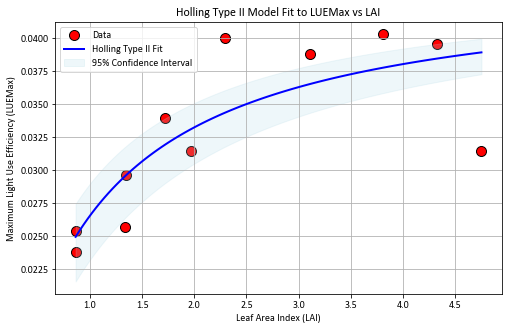

In [219]:
def min_max_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


# Define the Holling Type II Functional Response Model
def holling_type_II(LAI, a, h):
    return (a * LAI) / (1 + h * a * LAI)


tmp_types = types.drop("CRO")
num_measurements = site_annual_max_lue["type"].value_counts().drop("CRO")
num_measurements = num_measurements.reindex(tmp_types, fill_value=0).values

LAI = tmp_lai
LUEMax = tmp_lue
LAI_std = tmp_lai_std
LUE_std = tmp_lue_std


# Normalize standard deviations
LAI_std_normalized = min_max_normalize(LAI_std)
LUE_std_normalized = min_max_normalize(LUE_std)


# Calculate weights
weights = num_measurements / np.sqrt((LAI_std_normalized**2 + LUE_std_normalized**2))
weights = weights / np.sum(weights)  # Normalize weights to sum to 1


# Fit the model to the data
initial_guess = [1.0, 1.0]  # Initial guess for parameters a and h
params, covariance = curve_fit(
    holling_type_II,
    LAI,
    LUEMax,
    p0=initial_guess,
)

# Extract fitted parameters
a_fit, h_fit = params

# Calculate the standard deviations (uncertainties) of the parameters
param_errors = np.sqrt(np.diag(covariance))
a_error = param_errors[0]
h_error = param_errors[1]

# Print the fitted parameters with confidence intervals
print(
    f"Fitted parameters: a = {a_fit:.3f} ± {a_error:.3f}, h = {h_fit:.3f} ± {h_error:.3f}"
)

# Generate predicted values
LAI_fit = np.linspace(min(LAI), max(LAI), 100)  # More points for a smooth curve
LUEMax_fit = holling_type_II(LAI_fit, a_fit, h_fit)
# Define confidence intervals (assuming 1 standard deviation)
a_lower = a_fit - a_error
a_upper = a_fit + a_error
h_lower = h_fit - h_error
h_upper = h_fit + h_error

# Generate predicted values with confidence intervals
LAI_fit_upper = holling_type_II(LAI_fit, a_upper, h_fit)
LAI_fit_lower = holling_type_II(LAI_fit, a_lower, h_fit)

# Plot with confidence interval shading
plt.figure(figsize=(8, 5))
plt.scatter(LAI, LUEMax, label="Data", color="red", s=100, edgecolor="black")
plt.plot(LAI_fit, LUEMax_fit, label="Holling Type II Fit", color="blue", linewidth=2)
plt.fill_between(
    LAI_fit,
    LAI_fit_upper,
    LAI_fit_lower,
    alpha=0.2,
    color="lightblue",
    label="95% Confidence Interval",
)  # Adjust alpha for transparency
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Maximum Light Use Efficiency (LUEMax)")
plt.title("Holling Type II Model Fit to LUEMax vs LAI")
plt.legend()
plt.grid()
plt.show()

Fitted parameters: a = 0.054 ± 0.010, h = 18.627 ± 1.660


/tmp/ipykernel_1190051/1698644812.py:32: RuntimeWarning: divide by zero encountered in true_divide
  holling_type_II, LAI, LUEMax, p0=initial_guess, sigma=1 / weights


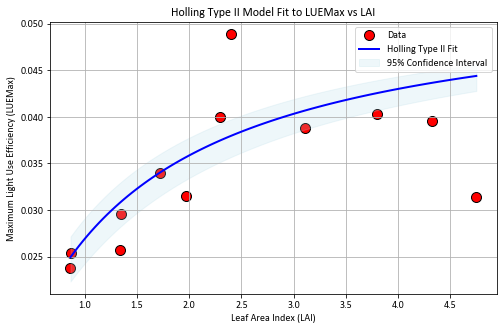

In [220]:
def min_max_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


# Define the Holling Type II Functional Response Model
def holling_type_II(LAI, a, h):
    return (a * LAI) / (1 + h * a * LAI)


num_measurements = site_annual_max_lue["type"].value_counts().drop("CRO")
num_measurements = num_measurements.reindex(types, fill_value=0).values

LAI = lai
LUEMax = lue
LAI_std = lai_std
LUE_std = lue_std


# Normalize standard deviations
LAI_std_normalized = min_max_normalize(LAI_std)
LUE_std_normalized = min_max_normalize(LUE_std)


# Calculate weights
weights = num_measurements / np.sqrt((LAI_std_normalized**2 + LUE_std_normalized**2))
weights = weights / np.sum(weights)  # Normalize weights to sum to 1


# Fit the model to the data
initial_guess = [0, 0]  # Initial guess for parameters a and h
params, covariance = curve_fit(
    holling_type_II, LAI, LUEMax, p0=initial_guess, sigma=1 / weights
)

# Extract fitted parameters
a_fit, h_fit = params

# Calculate the standard deviations (uncertainties) of the parameters
param_errors = np.sqrt(np.diag(covariance))
a_error = param_errors[0]
h_error = param_errors[1]

# Print the fitted parameters with confidence intervals
print(
    f"Fitted parameters: a = {a_fit:.3f} ± {a_error:.3f}, h = {h_fit:.3f} ± {h_error:.3f}"
)

# Generate predicted values
LAI_fit = np.linspace(min(LAI), max(LAI), 100)  # More points for a smooth curve
LUEMax_fit = holling_type_II(LAI_fit, a_fit, h_fit)
# Define confidence intervals (assuming 1 standard deviation)
a_lower = a_fit - a_error
a_upper = a_fit + a_error
h_lower = h_fit - h_error
h_upper = h_fit + h_error

# Generate predicted values with confidence intervals
LAI_fit_upper = holling_type_II(LAI_fit, a_upper, h_fit)
LAI_fit_lower = holling_type_II(LAI_fit, a_lower, h_fit)

# Plot with confidence interval shading
plt.figure(figsize=(8, 5))
plt.scatter(LAI, LUEMax, label="Data", color="red", s=100, edgecolor="black")
plt.plot(LAI_fit, LUEMax_fit, label="Holling Type II Fit", color="blue", linewidth=2)
plt.fill_between(
    LAI_fit,
    LAI_fit_upper,
    LAI_fit_lower,
    alpha=0.2,
    color="lightblue",
    label="95% Confidence Interval",
)  # Adjust alpha for transparency
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Maximum Light Use Efficiency (LUEMax)")
plt.title("Holling Type II Model Fit to LUEMax vs LAI")
plt.legend()
plt.grid()
plt.show()

In [146]:
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values

In [150]:
# Function to normalize data
def min_max_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


LAI = lai
LUEMax = lue
LAI_std = lai_std
LUE_std = lue_std

# Normalize standard deviations
LAI_std_normalized = min_max_normalize(LAI_std)
LUE_std_normalized = min_max_normalize(LUE_std)

# Calculate weights
weights = num_measurements / np.sqrt((LAI_std_normalized**2 + LUE_std_normalized**2))
weights = weights / np.sum(weights)  # Normalize weights to sum to 1

array([0.11405778, 0.03929922, 0.09339922, 0.20068041, 0.13931348,
       0.03899103, 0.09756461, 0.09388099, 0.06692872, 0.08170139,
       0.02367471, 0.01050844])

In [96]:
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values


def min_max_normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

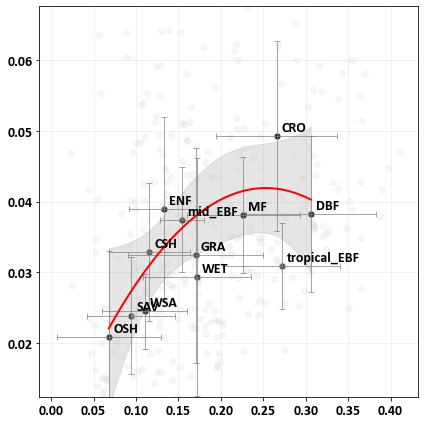


Fitted Equation:
LUE = 0.0049 +0.2929 * NIRV -0.5791 * NIRV^2

Fitted parameters:
Parameter 0: 0.0049 ± 0.0128
Parameter 1: 0.2929 ± 0.1446
Parameter 2: -0.5791 ± 0.3647

Confidence Intervals:
[[-0.02410002  0.03382878]
 [-0.03427267  0.62014978]
 [-1.40413406  0.24586679]]

P-values for coefficients:
Intercept: 0.7128
NIRV: 0.0735
NIRV^2: 0.1468

Model Summary:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            WLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     4.835
Date:                Fri, 04 Oct 2024   Prob (F-statistic):             0.0375
Time:                        09:51:27   Log-Likelihood:                 44.702
No. Observations:                  12   AIC:                            -83.40
Df Residuals:                       9   BIC:                            -81.95
Df

/home/hamid/anaconda3/envs/geospatial/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [113]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from matplotlib.font_manager import FontProperties


# Define a flexible polynomial function
def flexible_polynomial(x, *params):
    return np.polynomial.polynomial.polyval(x, params)


# Function to format the equation
def format_equation(params):
    terms = []
    for i, p in enumerate(params):
        if i == 0:
            terms.append(f"{p:.4f}")
        elif i == 1:
            terms.append(f"{p:+.4f} * NIRV")
        else:
            terms.append(f"{p:+.4f} * NIRV^{i}")
    return "LUE = " + " ".join(terms)


font = FontProperties()
font.set_weight("bold")
font.set_size(14)

# Calculate weights
# weights = num_measurements / np.sqrt((nirv_std**2 + lue_std**2))
# Normalize NIRV and LUE standard deviations
nirv_std_normalized = min_max_normalize(nirv_std)
lue_std_normalized = min_max_normalize(lue_std)

# Calculate weights using normalized standard deviations
weights = num_measurements / np.sqrt((nirv_std_normalized**2 + lue_std_normalized**2))

# Normalize weights to sum to 1
weights = weights / np.sum(weights)

# Perform weighted polynomial regression
degree = 2  # You can adjust this to change the flexibility of the model
X = sm.add_constant(np.column_stack([nirv**i for i in range(1, degree + 1)]))
wls_model = sm.WLS(lue, X, weights=weights)
results = wls_model.fit()

# Generate predictions for plotting
nirv_pred = np.linspace(np.min(nirv), np.max(nirv), 1000)
X_pred = sm.add_constant(np.column_stack([nirv_pred**i for i in range(1, degree + 1)]))
lue_pred = results.predict(X_pred)

# Calculate confidence intervals
conf_int = results.conf_int(alpha=0.05)

# Calculate prediction intervals
pred_interval = results.get_prediction(X_pred).conf_int(alpha=0.05)

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Add the background scatter plot
background_scatter = ax.plot(
    site_annual_max_lue["nirv"],
    site_annual_max_lue["lue"],
    "o",
    alpha=0.2,
    color="lightgray",
)

# Add error bars
(_, caps, _) = ax.errorbar(
    x=nirv,
    y=lue,
    xerr=[np.minimum(nirv, nirv_std), nirv_std],
    yerr=lue_std,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
# for cap in caps:
#     cap.set_markeredgewidth(1.5)

# Add black bullets for data points
ax.scatter(nirv, lue, color="black", alpha=0.8, edgecolor="white", s=50, label="Data")

# Plot fitted curve
ax.plot(nirv_pred, lue_pred, "r-", linewidth=2, label="Fitted Curve")

# Add prediction interval
ax.fill_between(
    nirv_pred,
    pred_interval[:, 0],
    pred_interval[:, 1],
    color="gray",
    alpha=0.2,
    label="95% Prediction Interval",
)

# # Add labels for each point
for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (nirv[i], lue[i]),
        fontsize=14,
        weight="bold",
        xytext=(5, 5),
        textcoords="offset points",
    )

# Enhance plot style
# ax.set_xlabel("NIRv", fontsize=20, weight="bold")
# ax.set_ylabel(r"LUE$_{Max}$", fontsize=20, weight="bold")
# ax.legend(fontsize=12)
# ax.set_title(
#     f"Polynomial Regression: NIRV vs LUE (Degree {degree})", fontsize=16, weight="bold"
# )
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)
# ax.tick_params(axis="both", which="major", labelsize=6)
for label in ax.get_xticklabels():
    label.set_fontproperties(font)

for label in ax.get_yticklabels():
    label.set_fontproperties(font)

# Set y-axis limits
main_data_ymin = min(lue) - 0.1 * (max(lue) - min(lue))
main_data_ymax = max(lue) + 0.1 * (max(lue) - min(lue))
background_ymin = np.percentile(site_annual_max_lue["lue"], 1)
background_ymax = np.percentile(site_annual_max_lue["lue"], 97.5)

ymin = max(min(main_data_ymin, background_ymin), 0)  # Ensure non-negative LUE
ymax = min(max(main_data_ymax, background_ymax), 1)  # Cap at 2 for reasonable scale

ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig("../outputs/figures/NIRV_vs_LUE_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# Print the equation
print("\nFitted Equation:")
print(format_equation(results.params))

# Print results
print("\nFitted parameters:")
for i, param in enumerate(results.params):
    print(f"Parameter {i}: {param:.4f} ± {results.bse[i]:.4f}")

print("\nConfidence Intervals:")
print(conf_int)
print("\nP-values for coefficients:")
for i, p_value in enumerate(results.pvalues):
    if i == 0:
        print(f"Intercept: {p_value:.4f}")
    elif i == 1:
        print(f"NIRV: {p_value:.4f}")
    else:
        print(f"NIRV^{i}: {p_value:.4f}")
print("\nModel Summary:")
print(results.summary())
print(f"\nAIC: {results.aic:.4f}")
print(f"BIC: {results.bic:.4f}")

# Calculate R-squared
r_squared = r2_score(lue, results.predict(X))
print(f"\nR-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")

# Perform model selection using AIC and BIC


# Calculate and print p-values for each coefficient


# Calculate overall p-value
f_statistic = results.fvalue
df_num = results.df_model
df_denom = results.df_resid
overall_p_value = stats.f.sf(f_statistic, df_num, df_denom)
print(f"\nOverall model p-value: {overall_p_value:.4f}")

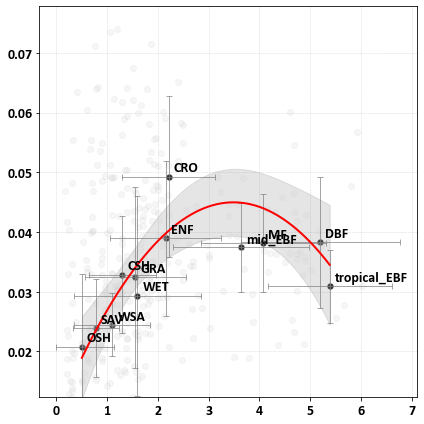


Fitted Equation:
LUE = 0.0095 +0.0203 * LAI -0.0029 * LAI^2

Fitted parameters:
Parameter 0: 0.0095 ± 0.0048
Parameter 1: 0.0203 ± 0.0041
Parameter 2: -0.0029 ± 0.0007

Confidence Intervals:
[[-0.00128874  0.02032119]
 [ 0.01093715  0.0296872 ]
 [-0.00447839 -0.0013404 ]]

Model Summary:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.765
Model:                            WLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     14.66
Date:                Thu, 03 Oct 2024   Prob (F-statistic):            0.00147
Time:                        11:21:47   Log-Likelihood:                 47.579
No. Observations:                  12   AIC:                            -89.16
Df Residuals:                       9   BIC:                            -87.70
Df Model:                           2                                         

/home/hamid/anaconda3/envs/geospatial/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [98]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Define a flexible polynomial function
def flexible_polynomial(x, *params):
    return np.polynomial.polynomial.polyval(x, params)


# Function to format the equation
def format_equation(params):
    terms = []
    for i, p in enumerate(params):
        if i == 0:
            terms.append(f"{p:.4f}")
        elif i == 1:
            terms.append(f"{p:+.4f} * LAI")
        else:
            terms.append(f"{p:+.4f} * LAI^{i}")
    return "LUE = " + " ".join(terms)


# Calculate weights
# weights = num_measurements / (lai_std**2 + lue_std**2)
# Normalize LAI and LUE standard deviations
lai_std_normalized = min_max_normalize(lai_std)
lue_std_normalized = min_max_normalize(lue_std)

# Calculate weights using normalized standard deviations
weights = num_measurements / np.sqrt((lai_std_normalized**2 + lue_std_normalized**2))

# Normalize weights to sum to 1
weights = weights / np.sum(weights)

# Perform weighted polynomial regression
degree = 2  # You can adjust this to change the flexibility of the model
X = sm.add_constant(np.column_stack([lai**i for i in range(1, degree + 1)]))
wls_model = sm.WLS(lue, X, weights=weights)
results = wls_model.fit()

# Generate predictions for plotting
lai_pred = np.linspace(np.min(lai), np.max(lai), 1000)
X_pred = sm.add_constant(np.column_stack([lai_pred**i for i in range(1, degree + 1)]))
lue_pred = results.predict(X_pred)

# Calculate confidence intervals
conf_int = results.conf_int(alpha=0.05)

# Calculate prediction intervals
pred_interval = results.get_prediction(X_pred).conf_int(alpha=0.05)

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Add the background scatter plot
background_scatter = ax.plot(
    site_annual_max_lue["lai"],
    site_annual_max_lue["lue"],
    "o",
    alpha=0.2,
    color="lightgray",
)

# Add error bars
(_, caps, _) = ax.errorbar(
    x=lai,
    y=lue,
    xerr=[np.minimum(lai, lai_std), lai_std],
    yerr=lue_std,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)


# Add black bullets for data points
ax.scatter(lai, lue, color="black", alpha=0.8, edgecolor="white", s=50, label="Data")

# Plot fitted curve
ax.plot(lai_pred, lue_pred, "r-", linewidth=2, label="Fitted Curve")

# Add prediction interval
ax.fill_between(
    lai_pred,
    pred_interval[:, 0],
    pred_interval[:, 1],
    color="gray",
    alpha=0.2,
    # label="95% Prediction Interval",
)

# Add labels for each point
for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (lai[i], lue[i]),
        fontsize=14,
        weight="bold",
        xytext=(5, 5),
        textcoords="offset points",
    )

# Enhance plot style
# ax.set_xlabel("LAI", fontsize=22, weight="bold")
# ax.set_ylabel(r"LUE$_{Max}$", fontsize=20, weight="bold")
# ax.legend(fontsize=12)
# ax.set_title(
#     f"Polynomial Regression: LAI vs LUE (Degree {degree})", fontsize=16, weight="bold"
# )
for label in ax.get_xticklabels():
    label.set_fontproperties(font)

for label in ax.get_yticklabels():
    label.set_fontproperties(font)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)
# ax.tick_params(axis="both", which="major", labelsize=12)


# Set y-axis limits
main_data_ymin = min(lue) - 0.1 * (max(lue) - min(lue))
main_data_ymax = max(lue) + 0.1 * (max(lue) - min(lue))
background_ymin = np.percentile(site_annual_max_lue["lue"], 1)
background_ymax = np.percentile(site_annual_max_lue["lue"], 99)

ymin = max(min(main_data_ymin, background_ymin), 0)  # Ensure non-negative LUE
ymax = min(max(main_data_ymax, background_ymax), 2)  # Cap at 2 for reasonable scale

ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig("../outputs/figures/LAI_vs_LUE_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# Print the equation
print("\nFitted Equation:")
print(format_equation(results.params))

# Print results
print("\nFitted parameters:")
for i, param in enumerate(results.params):
    print(f"Parameter {i}: {param:.4f} ± {results.bse[i]:.4f}")

print("\nConfidence Intervals:")
print(conf_int)

print("\nModel Summary:")
print(results.summary())

# Calculate R-squared
r_squared = r2_score(lue, results.predict(X))
print(f"\nR-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")

# Perform model selection using AIC and BIC
print(f"\nAIC: {results.aic:.4f}")
print(f"BIC: {results.bic:.4f}")

# Calculate and print p-values for each coefficient
print("\nP-values for coefficients:")
for i, p_value in enumerate(results.pvalues):
    if i == 0:
        print(f"Intercept: {p_value:.4f}")
    elif i == 1:
        print(f"LAI: {p_value:.4f}")
    else:
        print(f"LAI^{i}: {p_value:.4f}")

# Calculate overall p-value
f_statistic = results.fvalue
df_num = results.df_model
df_denom = results.df_resid
overall_p_value = stats.f.sf(f_statistic, df_num, df_denom)
print(f"\nOverall model p-value: {overall_p_value:.4f}")

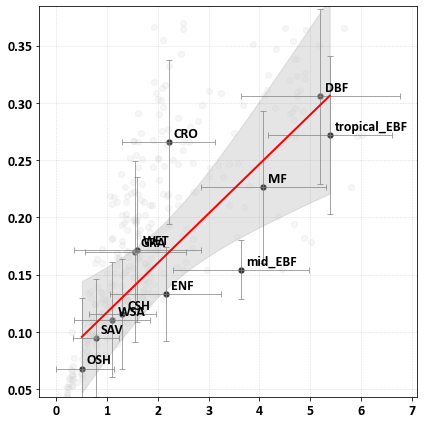


Fitted Equation:
NIRV = 0.0742 +0.0431 * LAI

Fitted parameters:
Parameter 0: 0.0742 ± 0.0263
Parameter 1: 0.0431 ± 0.0109

Confidence Intervals:
[[0.01549547 0.13289549]
 [0.01882826 0.06731777]]

Model Summary:
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.610
Model:                            WLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     15.67
Date:                Wed, 02 Oct 2024   Prob (F-statistic):            0.00269
Time:                        15:38:21   Log-Likelihood:                 18.803
No. Observations:                  12   AIC:                            -33.61
Df Residuals:                      10   BIC:                            -32.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                      

/home/hamid/anaconda3/envs/geospatial/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [21]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Define a flexible polynomial function
def flexible_polynomial(x, *params):
    return np.polynomial.polynomial.polyval(x, params)


# Function to format the equation
def format_equation(params):
    terms = []
    for i, p in enumerate(params):
        if i == 0:
            terms.append(f"{p:.4f}")
        elif i == 1:
            terms.append(f"{p:+.4f} * LAI")
        else:
            terms.append(f"{p:+.4f} * LAI^{i}")
    return "NIRV = " + " ".join(terms)


# Calculate weights
# Normalize NIRV and LUE standard deviations
nirv_std_normalized = min_max_normalize(nirv_std)
lai_std_normalized = min_max_normalize(lai_std)

# Calculate weights using normalized standard deviations
weights = num_measurements / np.sqrt((nirv_std_normalized**2 + lai_std_normalized**2))

# Normalize weights to sum to 1
weights = weights / np.sum(weights)

# Perform weighted polynomial regression
degree = 1  # You can adjust this to change the flexibility of the model
X = sm.add_constant(np.column_stack([lai**i for i in range(1, degree + 1)]))
wls_model = sm.WLS(nirv, X, weights=weights)
results = wls_model.fit()

# Generate predictions for plotting
lai_pred = np.linspace(np.min(lai), np.max(lai), 1000)
X_pred = sm.add_constant(np.column_stack([lai_pred**i for i in range(1, degree + 1)]))
nirv_pred = results.predict(X_pred)

# Calculate confidence intervals
conf_int = results.conf_int(alpha=0.05)

# Calculate prediction intervals
pred_interval = results.get_prediction(X_pred).conf_int(alpha=0.05)

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Add the background scatter plot
background_scatter = ax.plot(
    site_annual_max_lue["lai"],
    site_annual_max_lue["nirv"],
    "o",
    alpha=0.2,
    color="lightgray",
)

# Add error bars
(_, caps, _) = ax.errorbar(
    x=lai,
    y=nirv,
    xerr=[np.minimum(lai, lai_std), lai_std],
    yerr=nirv_std,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)


# Add black bullets for data points
ax.scatter(lai, nirv, color="black", alpha=0.8, edgecolor="white", s=50, label="Data")

# Plot fitted curve
ax.plot(lai_pred, nirv_pred, "r-", linewidth=2, label="Fitted Curve")

# Add prediction interval
ax.fill_between(
    lai_pred,
    pred_interval[:, 0],
    pred_interval[:, 1],
    color="gray",
    alpha=0.2,
    # label="95% Prediction Interval",
)

# Add labels for each point
for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (lai[i], nirv[i]),
        fontsize=14,
        weight="bold",
        xytext=(5, 5),
        textcoords="offset points",
    )

# Enhance plot style
# ax.set_xlabel("LAI", fontsize=14, weight="bold")
# ax.set_ylabel("NIRV", fontsize=14, weight="bold")
# ax.legend(fontsize=12)
# ax.set_title(
#     f"Polynomial Regression: LAI vs NIRV (Degree {degree})", fontsize=16, weight="bold"
# )
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)
# ax.tick_params(axis="both", which="major", labelsize=12)
for label in ax.get_xticklabels():
    label.set_fontproperties(font)

for label in ax.get_yticklabels():
    label.set_fontproperties(font)

# Set y-axis limits
main_data_ymin = min(nirv) - 0.1 * (max(nirv) - min(nirv))
main_data_ymax = max(nirv) + 0.1 * (max(nirv) - min(nirv))
background_ymin = np.percentile(site_annual_max_lue["nirv"], 1)
background_ymax = np.percentile(site_annual_max_lue["nirv"], 99)

ymin = max(min(main_data_ymin, background_ymin), 0)  # Ensure non-negative NIRV
ymax = min(
    max(main_data_ymax, background_ymax), 1
)  # Cap at 1 for reasonable scale (NIRV is typically between 0 and 1)

ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig("../outputs/figures/LAI_vs_NIRV_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# Print the equation
print("\nFitted Equation:")
print(format_equation(results.params))

# Print results
print("\nFitted parameters:")
for i, param in enumerate(results.params):
    print(f"Parameter {i}: {param:.4f} ± {results.bse[i]:.4f}")

print("\nConfidence Intervals:")
print(conf_int)

print("\nModel Summary:")
print(results.summary())

# Calculate R-squared
r_squared = r2_score(nirv, results.predict(X))
print(f"\nR-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")

# Perform model selection using AIC and BIC
print(f"\nAIC: {results.aic:.4f}")
print(f"BIC: {results.bic:.4f}")

# Calculate and print p-values for each coefficient
print("\nP-values for coefficients:")
for i, p_value in enumerate(results.pvalues):
    if i == 0:
        print(f"Intercept: {p_value:.4f}")
    elif i == 1:
        print(f"LAI: {p_value:.4f}")
    else:
        print(f"LAI^{i}: {p_value:.4f}")

# Calculate overall p-value
f_statistic = results.fvalue
df_num = results.df_model
df_denom = results.df_resid
overall_p_value = stats.f.sf(f_statistic, df_num, df_denom)
print(f"\nOverall model p-value: {overall_p_value:.4f}")

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Define a flexible polynomial function
def flexible_polynomial(x, *params):
    return np.polynomial.polynomial.polyval(x, params)


# Function to format the equation
def format_equation(params):
    terms = []
    for i, p in enumerate(params):
        if i == 0:
            terms.append(f"{p:.4f}")
        elif i == 1:
            terms.append(f"{p:+.4f} * LAI")
        else:
            terms.append(f"{p:+.4f} * LAI^{i}")
    return "NIRV = " + " ".join(terms)


# Calculate weights
weights = num_measurements / (lai_std**2 + nirv_std**2)

# Perform weighted polynomial regression
degree = 1  # You can adjust this to change the flexibility of the model
X = sm.add_constant(np.column_stack([lai**i for i in range(1, degree + 1)]))
wls_model = sm.WLS(nirv, X, weights=weights)
results = wls_model.fit()

# Generate predictions for plotting
lai_pred = np.linspace(np.min(lai), np.max(lai), 1000)
X_pred = sm.add_constant(np.column_stack([lai_pred**i for i in range(1, degree + 1)]))
nirv_pred = results.predict(X_pred)

# Calculate confidence intervals
conf_int = results.conf_int(alpha=0.05)

# Calculate prediction intervals
pred_interval = results.get_prediction(X_pred).conf_int(alpha=0.05)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

# Add error bars
(_, caps, _) = ax.errorbar(
    x=lai,
    y=nirv,
    xerr=[np.minimum(lai, lai_std), lai_std],
    yerr=nirv_std,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets for data points
ax.scatter(lai, nirv, color="black", alpha=0.8, edgecolor="white", s=50, label="Data")

# Plot fitted curve
ax.plot(lai_pred, nirv_pred, "r-", linewidth=2, label="Fitted Curve")

# Add prediction interval
ax.fill_between(
    lai_pred,
    pred_interval[:, 0],
    pred_interval[:, 1],
    color="gray",
    alpha=0.2,
    label="95% Prediction Interval",
)

# Add labels for each point
for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (lai[i], nirv[i]),
        fontsize=12,
        weight="bold",
        xytext=(5, 5),
        textcoords="offset points",
    )

# Enhance plot style
ax.set_xlabel("LAI", fontsize=14, weight="bold")
ax.set_ylabel("NIRV", fontsize=14, weight="bold")
ax.legend(fontsize=12)
ax.set_title(
    f"Polynomial Regression: LAI vs NIRV (Degree {degree})", fontsize=16, weight="bold"
)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)
ax.tick_params(axis="both", which="major", labelsize=12)

plt.tight_layout()
plt.show()

# Print the equation
print("\nFitted Equation:")
print(format_equation(results.params))

# Print results
print("\nFitted parameters:")
for i, param in enumerate(results.params):
    print(f"Parameter {i}: {param:.4f} ± {results.bse[i]:.4f}")

print("\nConfidence Intervals:")
print(conf_int)

print("\nModel Summary:")
print(results.summary())

# Calculate R-squared
r_squared = r2_score(nirv, results.predict(X))
print(f"\nR-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {results.rsquared_adj:.4f}")

# Perform model selection using AIC and BIC
print(f"\nAIC: {results.aic:.4f}")
print(f"BIC: {results.bic:.4f}")

# Calculate and print p-values for each coefficient
print("\nP-values for coefficients:")
for i, p_value in enumerate(results.pvalues):
    if i == 0:
        print(f"Intercept: {p_value:.4f}")
    elif i == 1:
        print(f"LAI: {p_value:.4f}")
    else:
        print(f"LAI^{i}: {p_value:.4f}")

# Calculate overall p-value
f_statistic = results.fvalue
df_num = results.df_model
df_denom = results.df_resid
overall_p_value = stats.f.sf(f_statistic, df_num, df_denom)
print(f"\nOverall model p-value: {overall_p_value:.4f}")

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming 'types', 'nirv_std', 'lue_std', 'nirv', and 'lue' are defined earlier in your code

# Count measurements for each type
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values

# Calculate weights as the inverse of the variance and number of measurements
weights = num_measurements / (nirv_std**2 + lue_std**2)

# Perform weighted linear regression
A = np.vstack([nirv, np.ones_like(nirv)]).T
weighted_A = A * np.sqrt(weights[:, np.newaxis])
weighted_lue = lue * np.sqrt(weights)

# Solve weighted least squares
beta_linear, _, _, _ = np.linalg.lstsq(weighted_A, weighted_lue, rcond=None)

# Perform weighted quadratic regression
A_quad = np.vstack([nirv**2, nirv, np.ones_like(nirv)]).T
weighted_A_quad = A_quad * np.sqrt(weights[:, np.newaxis])
beta_quadratic, _, _, _ = np.linalg.lstsq(weighted_A_quad, weighted_lue, rcond=None)

# Calculate p-values for linear fit
n = len(nirv)
y_pred_linear = beta_linear[0] * nirv + beta_linear[1]
residuals_linear = lue - y_pred_linear
sse_linear = np.sum(residuals_linear**2)
mse_linear = sse_linear / (n - 2)
se_linear = np.sqrt(mse_linear * np.diag(np.linalg.inv(np.dot(A.T, A))))
t_stats_linear = beta_linear / se_linear
p_values_linear = 2 * (1 - stats.t.cdf(np.abs(t_stats_linear), n - 2))

# Calculate p-values for quadratic fit
y_pred_quad = beta_quadratic[0] * nirv**2 + beta_quadratic[1] * nirv + beta_quadratic[2]
residuals_quad = lue - y_pred_quad
sse_quad = np.sum(residuals_quad**2)
mse_quad = sse_quad / (n - 3)
se_quad = np.sqrt(mse_quad * np.diag(np.linalg.inv(np.dot(A_quad.T, A_quad))))
t_stats_quad = beta_quadratic / se_quad
p_values_quad = 2 * (1 - stats.t.cdf(np.abs(t_stats_quad), n - 3))

# Plotting
plt.figure(figsize=(6, 6))

# Extract standard errors for lue and nirv
lue_se = lue_std
nirv_se = nirv_std

(_, caps, _) = plt.errorbar(
    x=nirv,
    y=lue,
    xerr=[np.minimum(nirv, nirv_se), nirv_se],
    yerr=lue_se,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets
plt.scatter(
    nirv,
    lue,
    color="black",
    alpha=0.8,
    edgecolor="white",
    s=50,
)

# Generate fitted values
x_min = nirv.min() - 0.05
x_max = nirv.max() + 0.05
nirv_fit = np.linspace(x_min, x_max, 100)
fit_line = beta_linear[0] * nirv_fit + beta_linear[1]
fit_quad = (
    beta_quadratic[0] * nirv_fit**2 + beta_quadratic[1] * nirv_fit + beta_quadratic[2]
)

# Plot linear and quadratic regression lines
plt.plot(nirv_fit, fit_line, color="black", linewidth=2, label="Weighted Linear Fit")
plt.plot(
    nirv_fit,
    fit_quad,
    color="red",
    linewidth=1,
    linestyle="--",
    label="Weighted Quadratic Fit",
)

# Calculate confidence intervals for linear fit
n = len(nirv)
mean_nirv = np.mean(nirv)
SS_x = np.sum((nirv - mean_nirv) ** 2)
SE_y_linear = np.sqrt(
    np.sum((lue - (beta_linear[0] * nirv + beta_linear[1])) ** 2) / (n - 2)
)
df_linear = n - 2
t_score_linear = stats.t.ppf((1 + 0.95) / 2, df_linear)

conf_interval_linear = (
    t_score_linear * SE_y_linear * np.sqrt(1 / n + (nirv_fit - mean_nirv) ** 2 / SS_x)
)
y_fit_upper_linear = fit_line + conf_interval_linear
y_fit_lower_linear = fit_line - conf_interval_linear

# Add the linear confidence interval as a shaded area
plt.fill_between(
    nirv_fit, y_fit_lower_linear, y_fit_upper_linear, color="gray", alpha=0.3
)

# Calculate confidence intervals for quadratic fit
X_quad = np.vstack([nirv_fit**2, nirv_fit, np.ones_like(nirv_fit)]).T
cov_matrix = np.linalg.inv(np.dot(weighted_A_quad.T, weighted_A_quad))
y_fit_quad = np.dot(X_quad, beta_quadratic)
SE_y_quad = np.sqrt(np.sum((lue - np.dot(A_quad, beta_quadratic)) ** 2) / (n - 3))
# weighted_residuals = np.sqrt(weights) * (lue - np.dot(A_quad, beta_quadratic))
# SE_y_quad = np.sqrt(np.sum(weighted_residuals**2) / (n - 3))
df_quad = n - 3
t_score_quad = stats.t.ppf((1 + 0.95) / 2, df_quad)

var_y_quad = np.sum(X_quad * np.dot(cov_matrix, X_quad.T).T, axis=1)
# var_y_quad = np.sum((X_quad @ cov_matrix) * X_quad, axis=1)

conf_interval_quad = t_score_quad * SE_y_quad * np.sqrt(var_y_quad)
y_fit_upper_quad = y_fit_quad + conf_interval_quad
y_fit_lower_quad = y_fit_quad - conf_interval_quad

# Add the quadratic confidence interval as a shaded area
plt.fill_between(nirv_fit, y_fit_lower_quad, y_fit_upper_quad, color="red", alpha=0.4)

# Get the current axes
ax = plt.gca()

# Add gridlines for better readability
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

plt.xticks(fontsize=12, weight="bold")
plt.yticks(fontsize=12, weight="bold")

plt.xlim(nirv.min() - 0.05, nirv.max() + 0.05)
plt.ylim(
    lue.min() - 0.02,
    lue.max() + 0.03,
)

plt.tight_layout()

# Calculate R-squared for the fits
r_squared_linear = r2_score(
    lue,
    beta_linear[0] * nirv + beta_linear[1],
)
r_squared_quadratic = r2_score(
    lue,
    beta_quadratic[0] * nirv**2 + beta_quadratic[1] * nirv + beta_quadratic[2],
)

# Overall p-value for linear model
F_linear = (r_squared_linear / 1) / ((1 - r_squared_linear) / (n - 2))
p_value_linear = 1 - stats.f.cdf(F_linear, 1, n - 2)

# Overall p-value for quadratic model
r_squared_null = r2_score(
    lue,
    [np.mean(lue)] * len(lue),
)
F_quadratic = ((r_squared_quadratic - r_squared_null) / 2) / (
    (1 - r_squared_quadratic) / (n - 3)
)
p_value_quadratic = 1 - stats.f.cdf(F_quadratic, 2, n - 3)

for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (
            nirv[i],
            lue[i],
        ),
        fontsize=12,
        weight="bold",
    )

# Modify the print statements to include overall p-values:
print(f"Linear fit: LUE_Max = {beta_linear[0]:.4f} * NIRV + {beta_linear[1]:.4f}")
print(f"Linear R-squared: {r_squared_linear:.4f}")
print(
    f"Linear p-values: NIRV: {p_values_linear[0]:.4f}, Intercept: {p_values_linear[1]:.4f}"
)
print(f"Linear overall p-value: {p_value_linear:.4f}")

print(
    f"Quadratic fit: LUE_Max = {beta_quadratic[0]:.4f} * NIRV^2 + {beta_quadratic[1]:.4f} * NIRV + {beta_quadratic[2]:.4f}"
)
print(f"Quadratic R-squared: {r_squared_quadratic:.4f}")
print(
    f"Quadratic p-values: NIRV^2: {p_values_quad[0]:.4f}, NIRV: {p_values_quad[1]:.4f}, Intercept: {p_values_quad[2]:.4f}"
)
print(f"Quadratic overall p-value: {p_value_quadratic:.4f}")

plt.xlabel("NIRV", fontsize=14, weight="bold")
plt.ylabel("LUE Max", fontsize=14, weight="bold")
plt.legend(fontsize=10)

plt.savefig("../outputs/figures/lue_nirv_regression.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming 'types', 'lai_std', 'lue_std', 'lai', and 'lue' are defined earlier in your code

# Count measurements for each type
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values

# Calculate weights as the inverse of the variance and number of measurements
weights = num_measurements / (lai_std**2 + lue_std**2)

# Perform weighted linear regression
A = np.vstack([lai, np.ones_like(lai)]).T
weighted_A = A * np.sqrt(weights[:, np.newaxis])
weighted_lue = lue * np.sqrt(weights)

# Solve weighted least squares
beta_linear, _, _, _ = np.linalg.lstsq(weighted_A, weighted_lue, rcond=None)

# Perform weighted quadratic regression
A_quad = np.vstack([lai**2, lai, np.ones_like(lai)]).T
weighted_A_quad = A_quad * np.sqrt(weights[:, np.newaxis])
beta_quadratic, _, _, _ = np.linalg.lstsq(weighted_A_quad, weighted_lue, rcond=None)

# Calculate p-values for linear fit
n = len(lai)
y_pred_linear = beta_linear[0] * lai + beta_linear[1]
residuals_linear = lue - y_pred_linear
sse_linear = np.sum(residuals_linear**2)
mse_linear = sse_linear / (n - 2)
se_linear = np.sqrt(mse_linear * np.diag(np.linalg.inv(np.dot(A.T, A))))
t_stats_linear = beta_linear / se_linear
p_values_linear = 2 * (1 - stats.t.cdf(np.abs(t_stats_linear), n - 2))

# Calculate p-values for quadratic fit
y_pred_quad = beta_quadratic[0] * lai**2 + beta_quadratic[1] * lai + beta_quadratic[2]
residuals_quad = lue - y_pred_quad
sse_quad = np.sum(residuals_quad**2)
mse_quad = sse_quad / (n - 3)
se_quad = np.sqrt(mse_quad * np.diag(np.linalg.inv(np.dot(A_quad.T, A_quad))))
t_stats_quad = beta_quadratic / se_quad
p_values_quad = 2 * (1 - stats.t.cdf(np.abs(t_stats_quad), n - 3))

# Plotting
plt.figure(figsize=(6, 6))

# Extract standard errors for lue and lai
lue_se = lue_std
lai_se = lai_std

(_, caps, _) = plt.errorbar(
    x=lai,
    y=lue,
    xerr=[np.minimum(lai, lai_se), lai_se],
    yerr=lue_se,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets
plt.scatter(
    lai,
    lue,
    color="black",
    alpha=0.8,
    edgecolor="white",
    s=50,
)

# Generate fitted values
x_min = lai.min() - 0.05
x_max = lai.max() + 0.05
lai_fit = np.linspace(x_min, x_max, 100)
fit_line = beta_linear[0] * lai_fit + beta_linear[1]
fit_quad = (
    beta_quadratic[0] * lai_fit**2 + beta_quadratic[1] * lai_fit + beta_quadratic[2]
)

# Plot linear and quadratic regression lines
plt.plot(lai_fit, fit_line, color="black", linewidth=2, label="Weighted Linear Fit")
plt.plot(
    lai_fit,
    fit_quad,
    color="red",
    linewidth=2,
    linestyle="--",
    label="Weighted Quadratic Fit",
)

# Calculate confidence intervals for linear fit
n = len(lai)
mean_lai = np.mean(lai)
SS_x = np.sum((lai - mean_lai) ** 2)
SE_y_linear = np.sqrt(
    np.sum((lue - (beta_linear[0] * lai + beta_linear[1])) ** 2) / (n - 2)
)
df_linear = n - 2
t_score_linear = stats.t.ppf((1 + 0.95) / 2, df_linear)

conf_interval_linear = (
    t_score_linear * SE_y_linear * np.sqrt(1 / n + (lai_fit - mean_lai) ** 2 / SS_x)
)
y_fit_upper_linear = fit_line + conf_interval_linear
y_fit_lower_linear = fit_line - conf_interval_linear

# Add the linear confidence interval as a shaded area
plt.fill_between(
    lai_fit, y_fit_lower_linear, y_fit_upper_linear, color="gray", alpha=0.3
)

# Calculate confidence intervals for quadratic fit
X_quad = np.vstack([lai_fit**2, lai_fit, np.ones_like(lai_fit)]).T
cov_matrix = np.linalg.inv(np.dot(weighted_A_quad.T, weighted_A_quad))
y_fit_quad = np.dot(X_quad, beta_quadratic)
SE_y_quad = np.sqrt(np.sum((lue - np.dot(A_quad, beta_quadratic)) ** 2) / (n - 3))
df_quad = n - 3
t_score_quad = stats.t.ppf((1 + 0.95) / 2, df_quad)

var_y_quad = np.sum(X_quad * np.dot(cov_matrix, X_quad.T).T, axis=1)
conf_interval_quad = t_score_quad * SE_y_quad * np.sqrt(var_y_quad)
y_fit_upper_quad = y_fit_quad + conf_interval_quad
y_fit_lower_quad = y_fit_quad - conf_interval_quad

# Add the quadratic confidence interval as a shaded area
plt.fill_between(lai_fit, y_fit_lower_quad, y_fit_upper_quad, color="red", alpha=0.1)

# Get the current axes
ax = plt.gca()

# Add gridlines for better readability
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

plt.xticks(fontsize=12, weight="bold")
plt.yticks(fontsize=12, weight="bold")

plt.xlim(0, 6)
plt.ylim(
    lue.min() - 0.02,
    lue.max() + 0.03,
)


plt.tight_layout()

# Calculate R-squared for the fits
r_squared_linear = r2_score(
    lue,
    beta_linear[0] * lai + beta_linear[1],
)
r_squared_quadratic = r2_score(
    lue,
    beta_quadratic[0] * lai**2 + beta_quadratic[1] * lai + beta_quadratic[2],
)

# Overall p-value for linear model
F_linear = (r_squared_linear / 1) / ((1 - r_squared_linear) / (n - 2))
p_value_linear = 1 - stats.f.cdf(F_linear, 1, n - 2)

# Overall p-value for quadratic model
r_squared_null = r2_score(
    lue,
    [np.mean(lue)] * len(lue),
)
F_quadratic = ((r_squared_quadratic - r_squared_null) / 2) / (
    (1 - r_squared_quadratic) / (n - 3)
)
p_value_quadratic = 1 - stats.f.cdf(F_quadratic, 2, n - 3)

for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (
            lai[i],
            lue[i],
        ),
        fontsize=12,
        weight="bold",
    )

# Modify the print statements to include overall p-values:
print(f"Linear fit: LUE_Max = {beta_linear[0]:.4f} * LAI + {beta_linear[1]:.4f}")
print(f"Linear R-squared: {r_squared_linear:.4f}")
print(
    f"Linear p-values: LAI: {p_values_linear[0]:.4f}, Intercept: {p_values_linear[1]:.4f}"
)
print(f"Linear overall p-value: {p_value_linear:.4f}")

print(
    f"Quadratic fit: LUE_Max = {beta_quadratic[0]:.4f} * LAI^2 + {beta_quadratic[1]:.4f} * LAI + {beta_quadratic[2]:.4f}"
)
print(f"Quadratic R-squared: {r_squared_quadratic:.4f}")
print(
    f"Quadratic p-values: LAI^2: {p_values_quad[0]:.4f}, LAI: {p_values_quad[1]:.4f}, Intercept: {p_values_quad[2]:.4f}"
)
print(f"Quadratic overall p-value: {p_value_quadratic:.4f}")

plt.xlabel("LAI", fontsize=14, weight="bold")
plt.ylabel("LUE Max", fontsize=14, weight="bold")

plt.savefig("../outputs/figures/lue_lai_regression.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming 'types', 'lai_std', 'nirv_std', 'lai', and 'nirv' are defined earlier in your code

# Count measurements for each type
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values

# Calculate weights as the inverse of the variance and number of measurements
weights = num_measurements / (lai_std**2 + nirv_std**2)

# Perform weighted linear regression
A = np.vstack([lai, np.ones_like(lai)]).T
weighted_A = A * np.sqrt(weights[:, np.newaxis])
weighted_nirv = nirv * np.sqrt(weights)

# Solve weighted least squares
beta_linear, _, _, _ = np.linalg.lstsq(weighted_A, weighted_nirv, rcond=None)

# Calculate p-values for linear fit
n = len(lai)
y_pred_linear = beta_linear[0] * lai + beta_linear[1]
residuals_linear = nirv - y_pred_linear
sse_linear = np.sum(residuals_linear**2)
mse_linear = sse_linear / (n - 2)
se_linear = np.sqrt(mse_linear * np.diag(np.linalg.inv(np.dot(A.T, A))))
t_stats_linear = beta_linear / se_linear
p_values_linear = 2 * (1 - stats.t.cdf(np.abs(t_stats_linear), n - 2))

# Plotting
plt.figure(figsize=(6, 6))

# Extract standard errors for nirv and lai
nirv_se = nirv_std
lai_se = lai_std

(_, caps, _) = plt.errorbar(
    x=lai,
    y=nirv,
    xerr=[np.minimum(lai, lai_se), lai_se],
    yerr=nirv_se,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets
plt.scatter(
    lai,
    nirv,
    color="black",
    alpha=0.8,
    edgecolor="white",
    s=50,
)

# Generate fitted values
x_min = lai.min() - 0.05
x_max = lai.max() + 0.05
lai_fit = np.linspace(x_min, x_max, 100)
fit_line = beta_linear[0] * lai_fit + beta_linear[1]

# Plot linear regression line
plt.plot(lai_fit, fit_line, color="black", linewidth=2, label="Weighted Linear Fit")

# Calculate confidence intervals for linear fit
n = len(lai)
mean_lai = np.mean(lai)
SS_x = np.sum((lai - mean_lai) ** 2)
SE_y_linear = np.sqrt(
    np.sum((nirv - (beta_linear[0] * lai + beta_linear[1])) ** 2) / (n - 2)
)
df_linear = n - 2
t_score_linear = stats.t.ppf((1 + 0.95) / 2, df_linear)

conf_interval_linear = (
    t_score_linear * SE_y_linear * np.sqrt(1 / n + (lai_fit - mean_lai) ** 2 / SS_x)
)
y_fit_upper_linear = fit_line + conf_interval_linear
y_fit_lower_linear = fit_line - conf_interval_linear

# Add the linear confidence interval as a shaded area
plt.fill_between(
    lai_fit, y_fit_lower_linear, y_fit_upper_linear, color="gray", alpha=0.3
)

# Get the current axes
ax = plt.gca()

# Add gridlines for better readability
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

plt.xticks(fontsize=12, weight="bold")
plt.yticks(fontsize=12, weight="bold")

# plt.xlim(0, 6)
# plt.ylim(
#     nirv.min() - 0.02,
#     nirv.max() + 0.03,
# )

plt.tight_layout()

# Calculate R-squared for the fit
r_squared_linear = r2_score(
    nirv,
    beta_linear[0] * lai + beta_linear[1],
)

# Overall p-value for linear model
F_linear = (r_squared_linear / 1) / ((1 - r_squared_linear) / (n - 2))
p_value_linear = 1 - stats.f.cdf(F_linear, 1, n - 2)

for i, txt in enumerate(types):
    ax.annotate(
        txt,
        (
            lai[i],
            nirv[i],
        ),
        fontsize=12,
        weight="bold",
    )

# Print results
print(f"Linear fit: NIRV = {beta_linear[0]:.4f} * LAI + {beta_linear[1]:.4f}")
print(f"Linear R-squared: {r_squared_linear:.4f}")
print(
    f"Linear p-values: LAI: {p_values_linear[0]:.4f}, Intercept: {p_values_linear[1]:.4f}"
)
print(f"Linear overall p-value: {p_value_linear:.4f}")

plt.savefig("../outputs/figures/nirv_lai_regression.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
site_annual_max_lue_grouped_mean

In [ ]:
from sklearn.linear_model import LinearRegression

pd.plotting.scatter_matrix(
    site_annual_max_lue[["lue", "fesc", "fpar", "nirv", "nirvp", "lai"]],
    alpha=0.2,
    figsize=(10, 10),
    diagonal="kde",
)
# Create a linear regression model
model = LinearRegression()

# Fit the model using "fesc" as the independent variable and "lue" as the dependent variable
model.fit(site_annual_max_lue[["lue"]], site_annual_max_lue[["nirv"]])

# Calculate the R score
# r_score = model.score(site_annual_max_lue[["lue"]], site_annual_max_lue[["fesc"]])
# print("R score:", r_score)
r = np.corrcoef(site_annual_max_lue["lue"], site_annual_max_lue["nirv"])[0, 1]
print("R:", r)

r_squared = r**2
print("R^2:", r_squared)

In [ ]:
site_annual_max_lue = site_annual_max_lue[site_annual_max_lue["fesc"] <= 1]
site_annual_max_lue_se = site_annual_max_lue_se[
    site_annual_max_lue_se.index.isin(site_annual_max_lue.index)
]
site_annual_max_lue_grouped_mean = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai"]]
    .groupby("type")
    .median()
)
site_annual_max_lue_grouped_std = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai"]]
    .groupby("type")
    .std()
)
n = site_annual_max_lue.groupby("type").size()
site_annual_max_lue_grouped_se = site_annual_max_lue_grouped_std.div(np.sqrt(n), axis=0)

In [ ]:
# site_annual_max_lue_grouped_mean = site_annual_max_lue_grouped_mean.drop(
#     ["DBF_low", "SAV_low", "EBF_mid"], errors="ignore"
# )

In [ ]:
site_annual_max_lue_grouped_mean

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("LUE", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)
plt.savefig("../outputs/figures/between_pft_scatter.png", dpi=300, bbox_inches="tight")

# Display the DataFrame with results
# print(results_df)

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lai"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("LAI", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)
# Display the DataFrame with results
# print(results_df)

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
plt.figure(figsize=(4, 4))
# host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# Plot 'lai' vs 'lue'
plt.scatter(df_to_plot["lai"], df_to_plot["lue"])

# Add labels next to the points
for line in range(df_to_plot.shape[0]):
    plt.text(
        df_to_plot["lai"].iloc[line],
        df_to_plot["lue"].iloc[line],
        df_to_plot.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Add labels to the axes
plt.xlabel("lai")
plt.ylabel("lue")

plt.tight_layout()
plt.show()

In [ ]:
site_annual_max_lue_grouped_mean["ci_lai"] = (
    site_annual_max_lue_grouped_mean["ci"] * site_annual_max_lue_grouped_mean["lai"]
)

In [ ]:
site_annual_max_lue_grouped_mean

In [ ]:
import matplotlib.pyplot as plt

lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
lai_values = site_annual_max_lue_grouped_mean["lai"].values

# Calculate the derivatives
dlue_dlai = np.gradient(lue_values, lai_values)
dnirv_dlai = np.gradient(nirv_values, lai_values)

# Add the derivatives back to the DataFrame
site_annual_max_lue_grouped_mean["dlue_dlai"] = dlue_dlai
site_annual_max_lue_grouped_mean["dnirv_dlai"] = dnirv_dlai

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot the 'dlue_dlai' derivative
site_annual_max_lue_grouped_mean.plot(x="lai", y="dlue_dlai", kind="scatter", ax=axs[0])

# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[0].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dlue_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Plot the 'dnirv_dlai' derivative
site_annual_max_lue_grouped_mean.plot(
    x="lai", y="dnirv_dlai", kind="scatter", ax=axs[1]
)
# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[1].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dnirv_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the R-squared value
# r2_linear = model.score(site_annual_max_lue_grouped_mean[['dlue_dlai']], site_annual_max_lue_grouped_mean[['dnirv_dlai']])

# Create a new figure
plt.figure(figsize=(6, 6))

# Plot the 'dnirv_dlai' derivative against the 'dlue_dlai' derivative
site_annual_max_lue_grouped_mean.plot(x="dlue_dlai", y="dnirv_dlai", kind="scatter")

# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    plt.text(
        site_annual_max_lue_grouped_mean["dlue_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean["dnirv_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Add the R-squared value to the plot
# plt.text(0.05, 0.95, f'R² = {r2_linear:.2f}', ha='left', va='top', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [ ]:
zi

In [ ]:
lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
ci_lai_values = site_annual_max_lue_grouped_mean["ci_lai"].values

# Calculate the derivatives
dlue_dci_lai = np.gradient(lue_values, ci_lai_values)
dnirv_dci_lai = np.gradient(nirv_values, ci_lai_values)

In [ ]:
plt.plot(ci_lai_values, dlue_dci_lai, "*")

In [ ]:
plt.plot(ci_lai_values, dnirv_dci_lai, "*")

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "struct"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("structure", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)


# Display the DataFrame with results
# print(results_df)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="lue", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
plt.ylim(0, 0.18)
ax.grid(color="gray", linestyle="-", alpha=0.3)
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_lue_box.png")

In [ ]:
cite = pd.read_csv("../data/citations_for_site_data_Ameriflux.csv", skiprows=5)
cite.rename(columns={"site_id": "name"}, inplace=True)

# Initialize an empty DataFrame to store the results
data_cite = []

for name in names:
    site_name = name
    site_type = df[df["name"] == name]["type"].values[0]
    t1 = df[df["name"] == name].index[0]
    t2 = df[df["name"] == name].index[-1]
    date_range = str(t1.date()) + " - " + str(t2.date())
    site_cite = cite[cite["name"] == name]

    if len(site_cite) == 0:
        doi_url = "FLUXNET2015"
        data_cite.append(
            {
                "Name": site_name,
                "Type": site_type,
                "Date Range": date_range,
                "URL": doi_url,
            }
        )
        continue
    doi_url = site_cite["doi_url"].values[0]
    data_cite.append(
        {
            "Name": site_name,
            "Type": site_type,
            "Date Range": date_range,
            "URL": doi_url,
        }
    )
data_cite = pd.DataFrame(data_cite)
data_cite.to_csv("../outputs/data_cite.csv", index=False)

In [ ]:
results = []
for type in types:
    df_type = df[df["type"] == type]
    number_of_sites = len(df_type["name"].unique())
    number_of_obs = len(df_type)
    results.append(
        {
            "Type": type,
            "Number of Sites": number_of_sites,
            "Number of Observations": number_of_obs,
        }
    )
results = pd.DataFrame(results)
results.to_csv("../outputs/data_summary.csv", index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="fesc", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
ax.grid(color="gray", linestyle="-", alpha=0.3)
ax.xaxis.label.set_weight("bold")
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_fesc_box.png")

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(
    style="white", context="paper", font_scale=0.8
)  # Changed style to "white" to remove grids

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(10, 2.5))  # Adjusted figure size
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Variable", "Slope", "Intercept", "R_squared"])

for i, x in enumerate(variables):
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Store slope, intercept, and R² in the DataFrame
    results_df.loc[i] = [x, model.coef_[0][0], model.intercept_[0], r2]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.01,
            df_to_plot[y].iloc[line] + 0.001,
            df_to_plot.index[line],
            horizontalalignment="center",
            size="small",
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )  # Reduced font size

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")  # Removing y-label
    if i == 0:
        host[i].set_ylabel(
            "LUE", fontsize=10, fontweight="bold"
        )  # Added y-label to the first subplot

plt.tight_layout(pad=0.01)  # Adjust subplot parameters to give specified padding
plt.savefig("../outputs/figures/between_pft_scatter.png", dpi=300, bbox_inches="tight")

# Display the DataFrame with results
print(results_df)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Load your data for site_annual_max_grouped_mean and site_annual_max_grouped_std
# Assuming these are already defined in your environment

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

for x in variables:
    # Create a single subplot with custom size
    fig, host = plt.subplots(1, 1, figsize=(3.5, 3.8))
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host,
        color="black",
        legend=False,
        s=50,
    )
    plt.errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_lue_grouped_se[x],
        yerr=site_annual_max_lue_grouped_se[y],
        fmt="none",
        color="black",
        alpha=0.25,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.002,
            df_to_plot[y].iloc[line] + 0.0005,
            df_to_plot.index[line],
            horizontalalignment="center",
            size=12,
            color="black",
            # weight="semibold",
        )

    # Add R² to the plot
    host.text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host.transAxes,
        fontsize=12,
        fontweight="bold",
    )

    # Set labels and title
    host.set_xlabel("")
    host.set_ylabel("")
    host.set_ylabel("")
    host.tick_params(axis="x", labelsize=12)
    host.tick_params(axis="y", labelsize=12)

    # Save the figure with x and y variables replaced in the filename
    plt.tight_layout(pad=0.01)
    plt.savefig(
        f"../outputs/figures/between_pft_{x}_{y}.png", dpi=300, bbox_inches="tight"
    )
    plt.clf()  # Clear the figure for the next iteration

# Close the figure
plt.close()

In [ ]:
site_annual_max_lue["type"].unique()

In [ ]:
types = site_annual_max_lue["type"].unique()

fig, axs = plt.subplots(3, 4, figsize=(10, 10))  # Reduced figure size to fit A4 paper
axs = axs.flatten()

for i, type in enumerate(types):
    print(type)
    x = "fesc"
    y = "lue"
    site_annual_max_type = site_annual_max_lue[site_annual_max_lue["type"] == type]
    site_annual_max_se_type = site_annual_max_lue_se[
        site_annual_max_lue_se["type"] == type
    ]
    df_to_plot = site_annual_max_type
    axs[i].scatter(
        df_to_plot[x], df_to_plot[y], color="black", marker="+", s=50
    )  # Added color, alpha, and edgecolor for better visualization
    axs[i].set_title(f"{type}", fontsize=12)  # Adjusted font size
    axs[i].set_xlabel(x, fontsize=12)  # Adjusted font size
    axs[i].set_ylabel("LUE$_{\mathrm{Max}}$", fontsize=12)

    axs[i].errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_se_type[x],
        yerr=site_annual_max_se_type[y],
        fmt="none",
        color="black",
        alpha=0.3,
    )

    # Calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    axs[i].text(
        0.1, 0.9, f"R² = {r:.2f}", transform=axs[i].transAxes, fontsize=12
    )  # Add R² to the plot
    axs[i].tick_params(axis="both", labelsize=8)  # Adjusted font size

# Remove the extra subplots
for j in range(len(types), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
# plt.savefig(
#     "../outputs/figures/within_pft_fesc_lue.png", dpi=300, bbox_inches="tight"
# )  # Adjusted file name and dpi

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

variables = ["fesc"]  # Variables to loop over
y = "lue"
site_r2 = {var: [] for var in variables}  # Initialize a dictionary to store R² values
site_types = []  # Initialize a list to store the types

for name in names:
    tmp_df = df[df["name"] == name]
    site_types.append(tmp_df["type"].iloc[0])  # Append the type of the site
    for x in variables:
        model = LinearRegression().fit(tmp_df[[x]], tmp_df[[y]])
        r2 = model.score(tmp_df[[x]], tmp_df[[y]])
        site_r2[x].append(r2)  # Append R² to the corresponding list in the dictionary

# Convert the dictionary to a pandas DataFrame
r2_df = pd.DataFrame(site_r2, index=names)
r2_df["type"] = site_types  # Add the types as a new column

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

name = names[1]
tmp_df = df[df["name"] == name]
x = "lue"
y = "apar"
# Melt the DataFrame to have a long format
r2_df_melted = r2_df.melt(id_vars="type", var_name="variable", value_name="r2")

# Remove 'SNO' and 'CVM' types
r2_df_melted = r2_df_melted[~r2_df_melted["type"].isin(["SNO", "CVM"])]

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(
    x="type", y="r2", hue="variable", data=r2_df_melted, color="white"
)
# plt.title("R² for different variables by type")

# Change legend labels
new_labels = [f"{var} vs LUE" for var in r2_df.columns if var != "type"]
for t, l in zip(box_plot.legend_.texts, new_labels):
    t.set_text(l)
# Add horizontal line
plt.axhline(y=0.5, color="red", linestyle="--", c="gray")

# Remove legend title
box_plot.legend_.set_title(None)
box_plot.legend_.remove()
box_plot.set_xlabel("")
box_plot.set_ylabel(r"$R^2$", fontsize=14)
box_plot.tick_params(axis="x", labelsize=12)
box_plot.tick_params(axis="y", labelsize=12)
plt.savefig(
    "../outputs/figures/within_sites_r2_fesc_lue.png", dpi=300, bbox_inches="tight"
)